In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Define values for rate constants (k)
k1 = 100000000       # kon for E + S to ES
k2 = 100       # koff for ES to E + S
k3 = 100000000      # kon for E + I to non-covalent EI
k4 = 10       # koff for EI to E + I
k5 = 0.001       # kon for EI to covalent EI*
k6 = 0       # koff for covalent EI* to non-covalent EI
kcat = 1    # kon ES to E+P
kdeg = 0.0005 # kdeg from E to Edeg

# Define concentrations at start of measurement t=0 (before addition of inhibitor or substrate)
E0 = 1*10**-12  #Unbound enzyme concentration E
ES0 = 0                 #Noncovalent enzyme-substrate complex ES
P0 = 0                   #Product
EI0 = 0                 #Non-covalent enzyme-inhibitor complex EI
EIi0 = 0                #Covalent enzyme-inhibitor complex (EI*) 
Edeg = 0                # Degraded E

#Define assay constants
Is =  [1*10**-9, 0*10**-9] # List of inhibitor concentrations. Is assumed to be constant, which is only true if inhibitor concentration is >10*E0.
S0 = 10000*10**-9 # Substrate concentration. Is assumed to be constant, which is only true if substrate conversion is less than 10%
dt = 0.0001 # Seconds per simulation step (dt). Minimum value for dt defined by k1*S0*dt < 1 and k3*I0*dt < 1

tframe =60 # Save a frame every 'tframe' seconds
tincub = 600 # Preincubate with inhibitor for 'tincub' seconds
tsub = 600 # Run with substrate for 'tsub' seconds

In [0]:
all_conc = []
all_t0 = []
all_t1 = []
for I in Is: # Loop over all I's
    all_conc.append(np.array([E0, ES0, P0, EI0, EIi0, Edeg], dtype=np.double)) #matrix van concentraties
    # Voor toevoeging van S

    S=0 # Geen S in je systeem
        
                            # [            E,       ES, P,     EI, EI*, Edeg]
    all_t0.append(np.array([[-k3*I-k1*S-kdeg,  k2+kcat, 0,     k4,   0,    0],  #E
                            [           k1*S, -k2-kcat, 0,      0,   0,    0],  #ES
                            [              0,     kcat, 0,      0,   0,    0],  #P
                            [           k3*I,        0, 0, -k4-k5,  k6,    0],  #EI
                            [              0,        0, 0,     k5, -k6,    0],  #EI*
                            [           kdeg,        0, 0,      0,   0,    0]]).T) #Edeg

    # Change in E    = [E]*(-k3*I-k1*S-kdeg) + [ES]*(k2+kcat)  + [P]*(0) + [EI]*(k4)     + [EI*]*(0)   + [Edeg]*(0)
    # Change in ES   = [E]*(k1*S)            + [ES]*(-k2-kcat) + [P]*(0) + [EI]*(0)      + [EI*]*(0)   + [Edeg]*(0)
    # Change in P    = [E]*(0)               + [ES]*(kcat)     + [P]*(0) + [EI]*(0)      + [EI*]*(0)   + [Edeg]*(0)
    # Change in EI   = [E]*(k3*I)            + [ES]*(0)        + [P]*(0) + [EI]*(-k4-k5) + [EI*]*(k6)  + [Edeg]*(0) 
    # Change in EI*  = [E]*(0)               + [ES]*(0)        + [P]*(0) + [EI]*(k5)     + [EI*]*(-k6) + [Edeg]*(0)
    # Change in Edeg = [E]*(kdeg)            + [ES]*(0)        + [P]*(0) + [EI]*(0)      + [EI*]*(0)   + [Edeg]*(0)


    #Na toevoeging van S
    S= S0
    all_t1.append(np.array([[-k3*I-k1*S-kdeg, k2+kcat, 0, k4, 0, 0],
                            [k1*S, -k2-kcat, 0, 0, 0, 0],
                            [0, kcat, 0, 0, 0, 0],
                            [k3*I, 0, 0, -k4-k5, k6, 0],
                            [0, 0, 0, k5, -k6, 0],
                            [kdeg, 0, 0, 0, 0, 0]]).T)
    # Maak een lijst van kopien van de concentraties
concentraties = np.stack(all_conc)  
t0 = np.stack(all_t0)
t1 = np.stack(all_t1)                
plot = [concentraties.copy()]

tijdconc = concentraties.copy()
t = 0
# Voor toevoging van S (tincub/dt stappen = 30min)
for i in range(int(tincub/dt)):
    t+= 1
    tijdconc += np.dot(tijdconc, t0*dt).diagonal().T
    #tijdconc += [diff[i].T[i] for i in range(len(Is))] # Doe 1 dt tijdstap
    if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")

    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

      # Na toevoeging van S (tsub/dt stappen)
for i in range(int(tsub/dt)):
    t += 1
    tijdconc += np.dot(tijdconc, t1*dt).diagonal().T   
    if (tijdconc < 0).any():
      raise ValueError("got a negative concentration, try decreasing dt")

    
    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

In [0]:
all_plots = np.array(plot).swapaxes(0,1) #swap ax 0 and ax 1

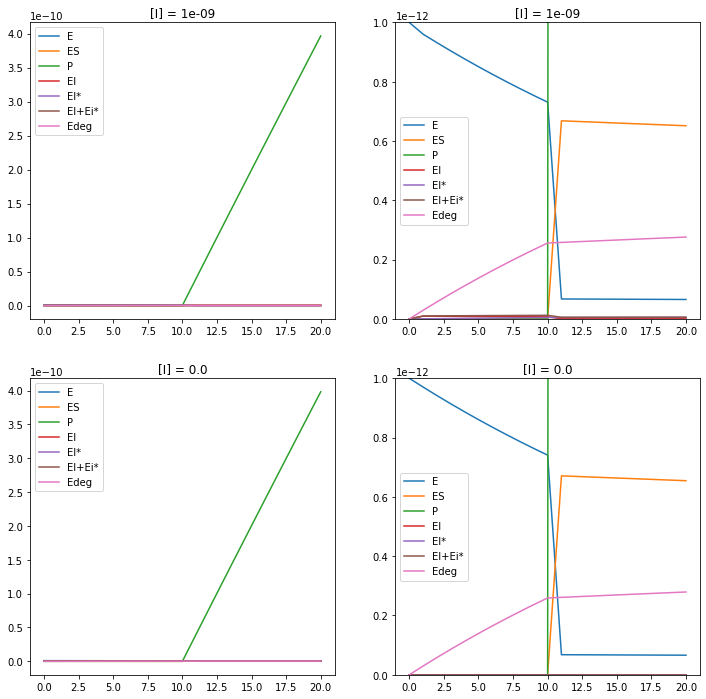

In [14]:
# This will make all the plots and dataframes
dataframes = []
fig, axes = plt.subplots(len(all_plots), 2, figsize=(12,len(all_plots)*6))
for n, plot in enumerate(all_plots):
  # Splits de lijst van figuren in E, ES, P, EI en EI*
  Eplot = [] 
  ESplot = []
  Pplot = []
  EIplot = []
  EIiplot = []
  EItot = []
  Edegplot = []
  for frame in plot:
    Eplot.append(frame[0])
    ESplot.append(frame[1])
    Pplot.append(frame[2])
    EIplot.append(frame[3])
    EIiplot.append(frame[4])
    EItot.append(frame[3]+frame[4]) 
    Edegplot.append(frame[5])
   # Plot de figuren
  labels = ('E', 'ES', "P", "EI", "EI*", "EI+Ei*", "Edeg")
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot, Edegplot)):
    axes[n,0].plot(y, label=labels[i])
  axes[n,0].legend()
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot, Edegplot)):
      axes[n,1].plot(y, label=labels[i])
  axes[n,1].legend()
  axes[n,1].set_ylim(0,E0) #zoom in tot E0
  axes[n,0].set_title("[I] = {}".format(str(Is[n])))
  axes[n,1].set_title("[I] = {}".format(str(Is[n])))
  
  df = pd.DataFrame(data={'E':Eplot,  "EI":EIplot, "EIi":EIiplot, "ES":ESplot, "P":Pplot,
                          "Edeg":Edegplot})
  dataframes.append(df)
df = pd.concat(dataframes, keys=[I for I in Is], axis=1) # Combine all the dataframes

In [15]:
df


1.000000e-09                ...  0.000000e+00              
               E            EI  ...             P          Edeg
0   1.000000e-12  0.000000e+00  ...  0.000000e+00  0.000000e+00
1   9.605528e-13  9.605052e-15  ...  0.000000e+00  2.955447e-14
2   9.318873e-13  9.318412e-15  ...  0.000000e+00  5.823547e-14
3   9.040773e-13  9.040326e-15  ...  0.000000e+00  8.606882e-14
4   8.770972e-13  8.770538e-15  ...  0.000000e+00  1.130796e-13
5   8.509223e-13  8.508802e-15  ...  0.000000e+00  1.392920e-13
6   8.255285e-13  8.254877e-15  ...  0.000000e+00  1.647298e-13
7   8.008926e-13  8.008529e-15  ...  0.000000e+00  1.894158e-13
8   7.769918e-13  7.769533e-15  ...  0.000000e+00  2.133721e-13
9   7.538043e-13  7.537670e-15  ...  0.000000e+00  2.366205e-13
10  7.313088e-13  7.312726e-15  ...  0.000000e+00  2.591818e-13
11  6.750549e-14  6.749906e-16  ...  4.031544e-11  2.612180e-13
12  6.731644e-14  6.731002e-16  ...  8.052069e-11  2.632484e-13
13  6.712791e-14  6.712151e-16  ...  1.206154e-10  2.652732e-13
14  6.693992e-14  6.693353e-16  ...  1.606000e-10  2.672924e-13
15  6.675245e-14  6.674608e-16  ...  2.004747e-10  2.693061e-13
16  6.656550e-14  6.655915e-16  ...  2.402398e-10  2.713142e-13
17  6.637908e-14  6.637275e-16  ...  2.798956e-10  2.733168e-13
18  6.619318e-14  6.618687e-16  ...  3.194424e-10  2.753140e-13
19  6.600780e-14  6.600151e-16  ...  3.588805e-10  2.773056e-13
20  6.582294e-14  6.581667e-16  ...  3.982103e-10  2.792917e-13

[21 rows x 12 columns]

In [16]:
# Printing the values at timepoint
df.iloc[30]

IndexError: ignored

In [0]:
print(df.to_csv())